<a href="https://colab.research.google.com/github/shandywong/World-Spending-Dashboard/blob/main/statsqueen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STEP 1: SETUP ENVIRONMENT AND DOWNLOAD LIBRARIES

In [ ]:
# Install necessary libraries
!pip install pandas numpy matplotlib seaborn nltk spacy wordcloud pyLDAvis transformers prophet

# Download language resources
import nltk
nltk.download("stopwords")

!python -m spacy download en_core_web_sm


STEP 2: LOAD ALL THE DATASETS FROM CSV FILE such as comments1.csv to comments5.csv, and also videos.csv

In [ ]:
import pandas as pd

# Load comments dataset (combine 5 files)
comments = pd.concat([
    pd.read_csv("/content/comments1.csv"),
    pd.read_csv("/content/comments2.csv"),
    pd.read_csv("/content/comments3.csv"),
    pd.read_csv("/content/comments4.csv"),
    pd.read_csv("/content/comments5.csv")
], ignore_index=True)

# Load video dataset
videos = pd.read_csv("/content/videos.csv")

print("Comments dataset:")
print(comments.head())
print("\nVideos dataset:")
print(videos.head())


STEP 3: DATA CLEANING WITH THE COMMENTS DATASET

In [ ]:
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

def clean_comment(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)   # remove links
    text = re.sub(r"@\w+|#\w+", "", text)                 # remove mentions & hashtags
    text = re.sub(r"[^a-zA-Z\s]", "", text)               # remove numbers/punct
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)

# Apply cleaning
comments["clean_text"] = comments["textOriginal"].apply(clean_comment)

# Remove empty/very short comments
comments = comments[comments["clean_text"].str.len() > 3]

print("After cleaning:", comments.shape)
comments[["textOriginal","clean_text"]].head(10)


After cleaning: (3937527, 11)


,textOriginal,clean_text
0,PLEASE LESBIAN FLAG I BEG YOU \r\n\r\nYou woul...,please lesbian flag beg would rock
1,Apply mashed potato juice and mixed it with curd,apply mashed potato juice mixed curd
2,69 missed calls from mars👽,missed calls mars
3,Baaa,baaa
4,you look like raven from phenomena raven no cap,look like raven phenomena raven cap
5,American,american
6,Sahi disha me ja ja raha india ka Future..,sahi disha ja ja raha india ka future
8,Love your videos. Thank you ❤❤❤,love videos thank
9,India is the best and very beautiful 😍😍😍😍😍😍😍...,india best beautiful
11,This is so true. Skinny jeans always nipped me😭😭😭,true skinny jeans always nipped


STEP 4: MERGE COMMENTS + VIDEOS

In [ ]:
# STEP 4: Merge comments and videos datasets on videoId
merged = comments.merge(
    videos[["videoId", "title", "tags", "viewCount", "commentCount", "publishedAt"]],
    on="videoId", how="left"
)

merged.head()


,kind,commentId,channelId,videoId,authorId,textOriginal,parentCommentId,likeCount,publishedAt_x,updatedAt,clean_text,title,tags,viewCount,commentCount,publishedAt_y
0,youtube#comment,1781382,14492,74288,2032536,PLEASE LESBIAN FLAG I BEG YOU \r\n\r\nYou woul...,NaN,0,2023-08-15 21:48:52+00:00,2023-08-15 21:48:52+00:00,please lesbian flag beg would rock,I tried hair inspired by the PAN flag 🩷💛🩵 #pan...,NaN,9856583.0,5901.0,2023-08-15 21:22:52+00:00
1,youtube#comment,289571,14727,79618,3043229,Apply mashed potato juice and mixed it with curd,3198066.0,0,2023-10-02 13:08:22+00:00,2023-10-02 13:08:22+00:00,apply mashed potato juice mixed curd,5 Foundation Mistakes that Every Girl Should Know,"['makeup mistakes to avoid', 'common makeup mi...",1148157.0,164.0,2023-10-01 06:30:15+00:00
2,youtube#comment,569077,3314,51826,917006,69 missed calls from mars👽,NaN,0,2024-05-31 12:03:12+00:00,2024-05-31 12:03:12+00:00,missed calls mars,How To Make Small Eyes Look Bigger,"['How To Make Small Eyes Look Bigger', 'eye ma...",14590307.0,4226.0,2023-03-05 17:36:18+00:00
3,youtube#comment,2957962,5008,58298,1853470,Baaa,NaN,0,2024-02-13 15:48:37+00:00,2024-02-13 15:48:37+00:00,baaa,20sec beauty test: BLUSH PLACEMENT for YOUR FA...,NaN,153902.0,286.0,2024-02-13 14:02:42+00:00
4,youtube#comment,673093,21411,1265,2584166,you look like raven from phenomena raven no cap,NaN,0,2020-02-15 22:28:44+00:00,2020-02-15 22:28:44+00:00,look like raven phenomena raven cap,BLACK GIRL TRIES KYLIE JENNER MAKEUP,"['kylie jenner', 'kylie cosmetics', 'black gir...",12347504.0,19920.0,2020-01-23 21:00:00+00:00


STEP 5: EXTRACT KEYWORDS AND TRENDS

In [ ]:
#from comments
from collections import Counter

all_words = " ".join(merged["clean_text"]).split()
common_words = Counter(all_words).most_common(20)
print("Top 20 comment keywords:", common_words)

#from tags and titles
tag_words = []
for tags in merged["tags"].dropna():
    tag_words.extend([t.lower() for t in str(tags).split(",")])

common_tags = Counter(tag_words).most_common(20)
print("Top 20 video tags:", common_tags)


Top 20 comment keywords: [('like', 331355), ('hair', 307446), ('beautiful', 299302), ('makeup', 269261), ('look', 252655), ('love', 246754), ('dont', 179431), ('im', 149568), ('u', 147357), ('girl', 127389), ('pretty', 121303), ('please', 120187), ('good', 118005), ('make', 117493), ('looks', 111785), ('one', 100641), ('people', 92744), ('hai', 89806), ('skin', 89794), ('much', 88972)]
Top 20 video tags: [(" 'makeup'", 320096), (" 'makeup shorts'", 255307), (" 'makeup tutorial'", 230655), (" 'beauty'", 219959), (" 'makeup challenge'", 203401), ("['makeup'", 167481), (" 'viral makeup challenge'", 165126), (" 'makeup trends'", 159927), (" 'sugar cosmetics'", 157610), (" 'red lipstick'", 141989), (" 'sugar youtube channel'", 140057), (" 'traditional makeup'", 135536), (" 'makeup transformation'", 130895), (" 'traditional makeup look'", 124828), (" 'indian makeup look'", 112311), (" 'makeup artist'", 112164), (" 'lipstick'", 110540), (" 'pakistani makeup look'", 108563), (" 'shorts'", 1063

STEP 6: SENTIMENT ANALYSIS

In [ ]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")

# Example: run on first 20 comments
sample_comments = merged["clean_text"].head(20).tolist()
sentiments = sentiment_pipeline(sample_comments)

merged.loc[0:19, "sentiment"] = [s["label"] for s in sentiments]
merged[["clean_text","sentiment"]].head(20)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


,clean_text,sentiment
0,please lesbian flag beg would rock,NEGATIVE
1,apply mashed potato juice mixed curd,NEGATIVE
2,missed calls mars,NEGATIVE
3,baaa,NEGATIVE
4,look like raven phenomena raven cap,POSITIVE
5,american,POSITIVE
6,sahi disha ja ja raha india ka future,NEGATIVE
7,love videos thank,POSITIVE
8,india best beautiful,POSITIVE
9,true skinny jeans always nipped,POSITIVE


STEP 7: TREND GROWTH AND DECAY

/tmp/ipython-input-1091468016.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  trend_time = merged.groupby(merged["publishedAt"].dt.to_period("M")).size()


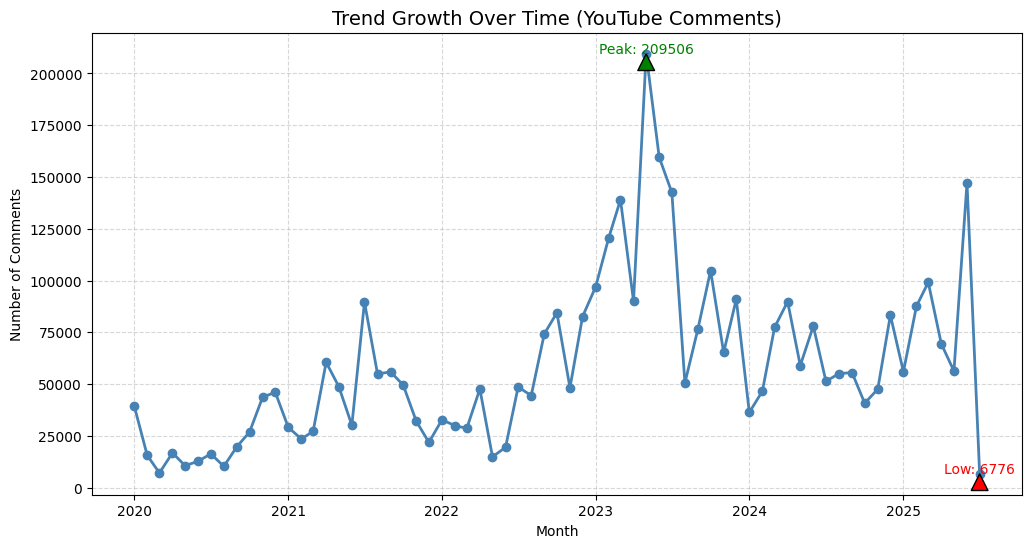

In [ ]:
# --- Step 7: Prepare time series for trend analysis ---

# Rename publishedAt_y → publishedAt for clarity
if "publishedAt_y" in merged.columns:
    merged = merged.rename(columns={"publishedAt_y": "publishedAt"})

# Convert to datetime
merged["publishedAt"] = pd.to_datetime(merged["publishedAt"], errors="coerce")

# Group by month to see trend growth
trend_time = merged.groupby(merged["publishedAt"].dt.to_period("M")).size()

# Reset index to make Prophet-ready
df = trend_time.reset_index()
df["publishedAt"] = df["publishedAt"].dt.to_timestamp()
df.columns = ["ds", "y"]

# Find peaks and drops
max_point = df.loc[df["y"].idxmax()]
min_point = df.loc[df["y"].idxmin()]

# Plot with annotations
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df["ds"], df["y"], marker="o", color="steelblue", linewidth=2)
plt.title("Trend Growth Over Time (YouTube Comments)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Number of Comments")

# Annotate max point
plt.annotate(f"Peak: {max_point['y']}",
             xy=(max_point["ds"], max_point["y"]),
             xytext=(max_point["ds"], max_point["y"]+200),
             arrowprops=dict(facecolor='green', shrink=0.05),
             ha="center", fontsize=10, color="green")

# Annotate min point
plt.annotate(f"Low: {min_point['y']}",
             xy=(min_point["ds"], min_point["y"]),
             xytext=(min_point["ds"], min_point["y"]+200),
             arrowprops=dict(facecolor='red', shrink=0.05),
             ha="center", fontsize=10, color="red")

plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


Forecast future trend activity with Prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx4yy611z/w8duew2p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx4yy611z/xlnfpnl4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88170', 'data', 'file=/tmp/tmpx4yy611z/w8duew2p.json', 'init=/tmp/tmpx4yy611z/xlnfpnl4.json', 'output', 'file=/tmp/tmpx4yy611z/prophet_modelpd5rummq/prophet_model-20250913100103.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:01:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:01:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages

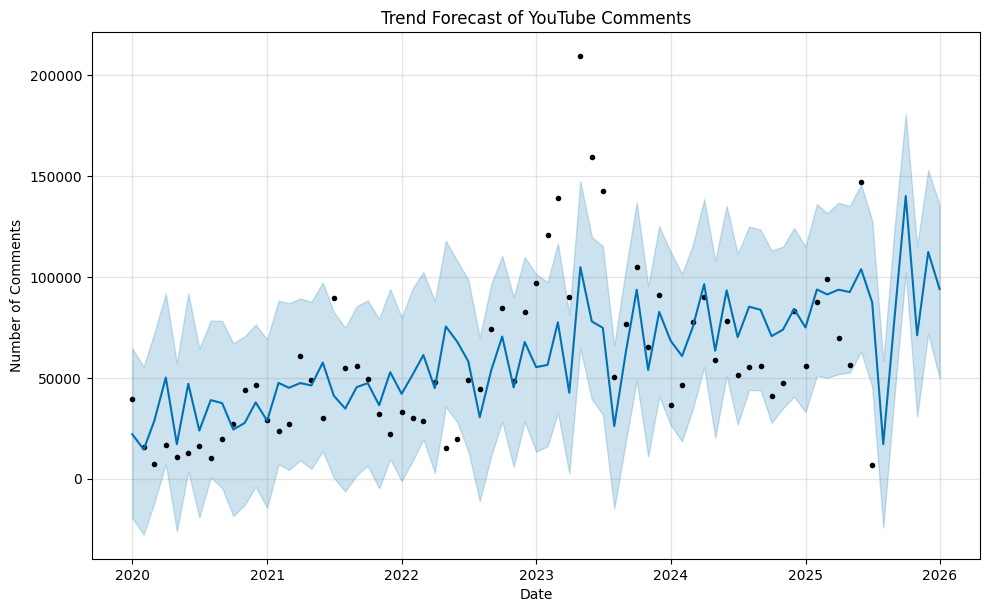

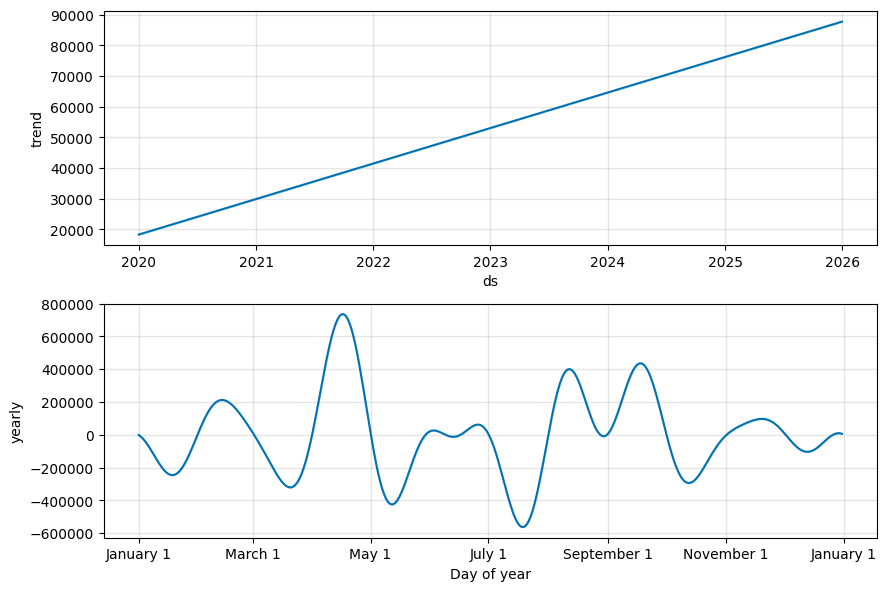

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Reset index and convert Period to Timestamp for Prophet
df = trend_time.reset_index()
df["publishedAt"] = df["publishedAt"].dt.to_timestamp()

# Prophet requires ds (date) and y (value)
df.columns = ["ds", "y"]

# Initialize and fit Prophet model
model = Prophet()
model.fit(df)

# Create future dataframe (6 months ahead)
future = model.make_future_dataframe(periods=6, freq="M")

# Forecast
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title("Trend Forecast of YouTube Comments")
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.show()

# Optional: Plot forecast components (seasonality, trend)
fig2 = model.plot_components(forecast)
plt.show()




---



Top 5 Trending Titles:
title
Which is your favortie? #hairstyle #shortvideo #shorts #short       48583
BALD, Blonde, or Ginger???                                          44232
what men think no makeup is #makeup                                 39711
☀️Day Vs🌙Night Makeup Look😍 | #shorts | SUGAR⁩ Cosmetics            36495
🇮🇳Indian Vs 🇵🇰Pakistan Makeup Look😍 | #shorts | SUGAR⁩ Cosmetics    36131
Name: count, dtype: int64

Top 5 Hashtags:
hashtags
#1                         549
#superstyletipsgiveaway    520
#jalfam                    491
#jalway                    467
#2                         440
Name: count, dtype: int64

Top 5 Keywords:
textOriginal
like         333269
hair         310487
beautiful    301932
she          296220
makeup       261694
Name: count, dtype: int64


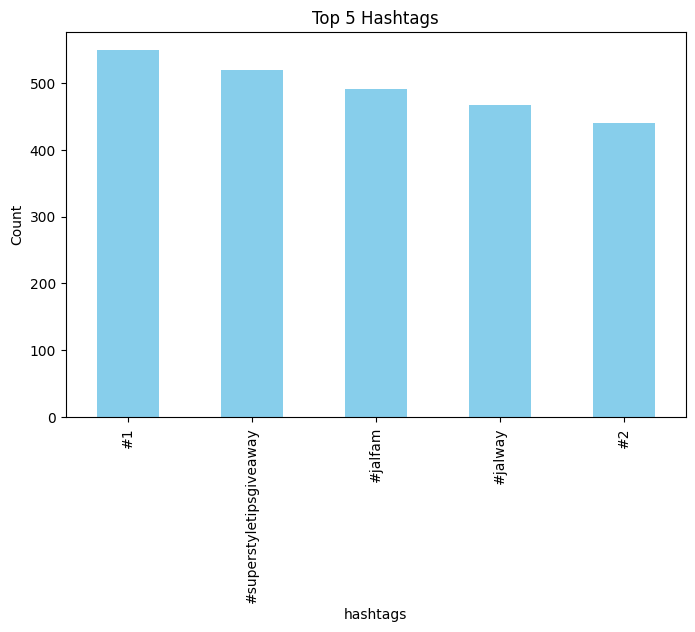

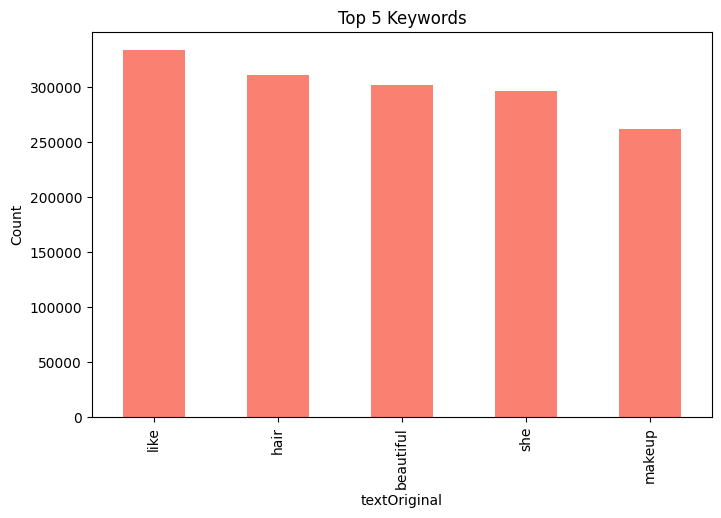

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127769 (\N{CRESCENT MOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8297 (\N{POP DIRECTIONAL ISOLATE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127470 (\N{REGIONAL INDICATOR SYMBOL LETTER I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127475 (\N{REGIONAL INDICATOR SYMBOL LETTER N}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127477 (\N{REGIONAL INDICATOR SYMBOL LETTER P}) missing from font(s) DejaVu Sans.
 

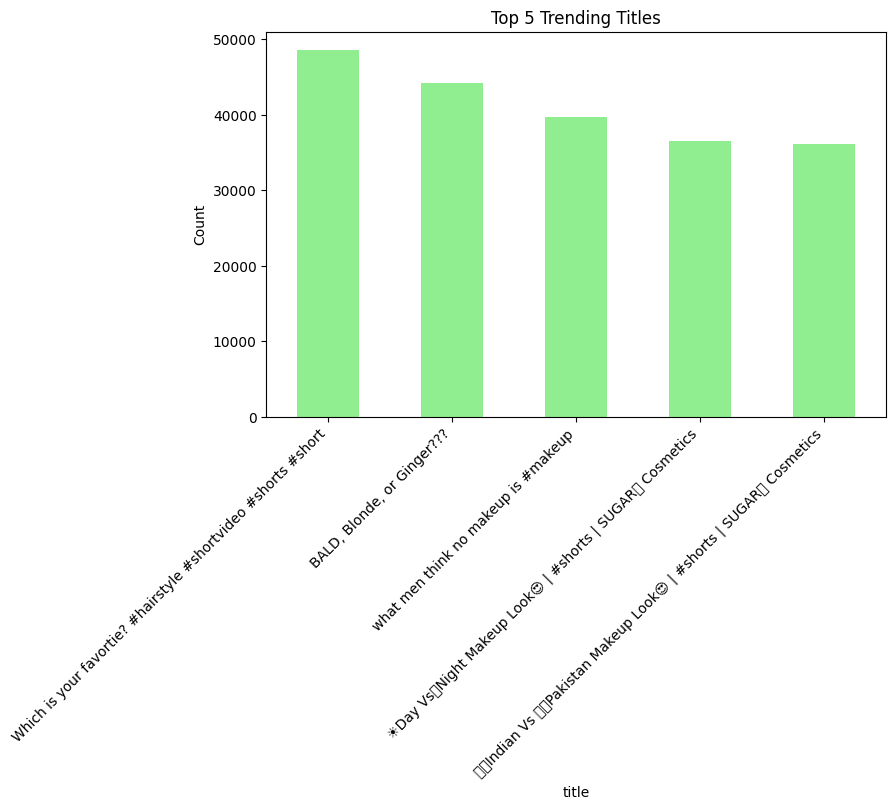

In [ ]:
# --- Step 1: Extract Trending Titles ---
if "title" in merged.columns:
    trending_titles = merged["title"].value_counts().head(5)
    print("Top 5 Trending Titles:")
    print(trending_titles)
else:
    print("⚠️ No 'title' column found in merged dataset.")

# --- Step 2: Extract Hashtags ---
import re

def extract_hashtags(text):
    return re.findall(r"#\w+", str(text))

merged["hashtags"] = merged["textOriginal"].apply(extract_hashtags)
all_hashtags = merged["hashtags"].explode().dropna()
top_hashtags = all_hashtags.value_counts().head(5)

print("\nTop 5 Hashtags:")
print(top_hashtags)

# --- Step 3: Extract Keywords ---
from collections import Counter

stopwords = set([
    "the","and","a","to","of","is","in","it","for","on","this","that",
    "with","i","you","my","at","we","our","your","they","are","be"
])

def extract_keywords(text):
    words = re.findall(r"\b\w+\b", str(text).lower())
    return [w for w in words if w not in stopwords and len(w) > 2]

all_keywords = merged["textOriginal"].apply(extract_keywords).explode().dropna()
top_keywords = all_keywords.value_counts().head(5)

print("\nTop 5 Keywords:")
print(top_keywords)

# --- Step 4: Visualization ---
import matplotlib.pyplot as plt

# Bar plot for hashtags
plt.figure(figsize=(8,5))
top_hashtags.plot(kind="bar", color="skyblue", title="Top 5 Hashtags")
plt.ylabel("Count")
plt.show()

# Bar plot for keywords
plt.figure(figsize=(8,5))
top_keywords.plot(kind="bar", color="salmon", title="Top 5 Keywords")
plt.ylabel("Count")
plt.show()

# Bar plot for titles
if "title" in merged.columns:
    plt.figure(figsize=(8,5))
    trending_titles.plot(kind="bar", color="lightgreen", title="Top 5 Trending Titles")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.show()

# --- Step 5: Alternative Visualization (Word Cloud for keywords) ---
from wordcloud import WordCloud

text_data = " ".join(all_keywords.dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Keyword Word Cloud", fontsize=16)
plt.show()